In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import numpy as np
import matplotlib.patches as patches

In [72]:
root = Path.cwd().parent

five_fold_results_dir = root / "RESULTS_fiveFold" / "results"
five_fold_aggregated_csv = five_fold_results_dir / "results5Fold_summary_combined.csv"

data = pd.read_csv(five_fold_aggregated_csv, keep_default_na=False)
# drop the rows where dropExecTime is True
df = data[data['dropExecTime'] == False]
# drop the column dropExecTime
df = df.drop(columns=['dropExecTime'])

model_groups = df.groupby('model_name')



In [73]:
# Set style and palette globally
sns.set(style="whitegrid", context="talk")
palette = 'colorblind'

In [74]:
# --- Function to determine config ---
def get_config(row):
    if row['kbest']:
        return f'kbest_{int(row["features"])}'
    for col in ['lowVarianceDrop', 'rfecv', 'autospearman', 'hyperparameters']:
        if row[col]:
            return col
    return 'All_features'

def plot_model_config_r2(model_name: str, df: pd.DataFrame, ax=None):
    import matplotlib.patches as mpatches

    group_df = df[df['model_name'] == model_name].copy()
    group_df['config'] = group_df.apply(get_config, axis=1)
    # replace 'lowVarianceDrop'
    group_df['config'] = group_df['config'].replace('lowVarianceDrop', 'variance threshold >0.01')


    unique_configs = sorted(group_df['config'].unique())
    config_code_map = {cfg: f't{i}' for i, cfg in enumerate(unique_configs)}
    group_df['config_code'] = group_df['config'].map(config_code_map)

    group_df = group_df.sort_values(by='config_code')

    if ax is None:
        fig, ax = plt.subplots()

    group_df['r2_original'] = group_df['r2_mean']
    # do not show negative values on y-axis
    group_df['r2_mean'] = group_df['r2_mean'].clip(lower=0)
    sns.barplot(data=group_df, x='config_code', y='r2_mean', palette=palette, ax=ax)

    # Annotate clipped bars with original value (rounded to 2 decimal places)
    for bar, (_, row) in zip(ax.patches, group_df.iterrows()):
        if row['r2_original'] < 0:
            x = bar.get_x() + bar.get_width() / 2
            y = bar.get_height()
            ax.text(x, y + 0.01, f"{row['r2_original']:.2f}",
                    ha='center', va='bottom', color='red', fontweight='bold')
    
    
    # Draw a dashed box around the 'all_features' bar
    for bar, (_, row) in zip(ax.patches, group_df.iterrows()):
        if row['config'] == 'All_features':
            x0 = bar.get_x()
            x1 = bar.get_x() + bar.get_width()
            y0 = 0
            y1 = bar.get_height() + 0.00  # slight padding

            rect = patches.Rectangle(
                (x0, y0),
                x1 - x0,
                y1 - y0,
                linewidth=1.6,
                edgecolor='maroon',
                linestyle='--',
                facecolor='none',
                zorder=10
            )
            ax.add_patch(rect)
            break
        
    ax.set_title(model_name, fontweight='bold')
    ax.set_xlabel('Feature Selection Technique')
    ax.set_ylabel('R²')
    ax.tick_params(axis='x')
    
    
        
    # Legend (return for use outside)
    handles = [mpatches.Patch(color='none', label=f'{code}: {name}')
               for name, code in config_code_map.items()]
    
    return ax, handles  # returns both plot and legend handles


Model names: ['RF', 'GB', 'ADA', 'HGB', 'LassoR', 'kNN', 'RidgeR', 'SVM', 'LR', 'MLP', 'DT']
Collected 7 unique legend handles.


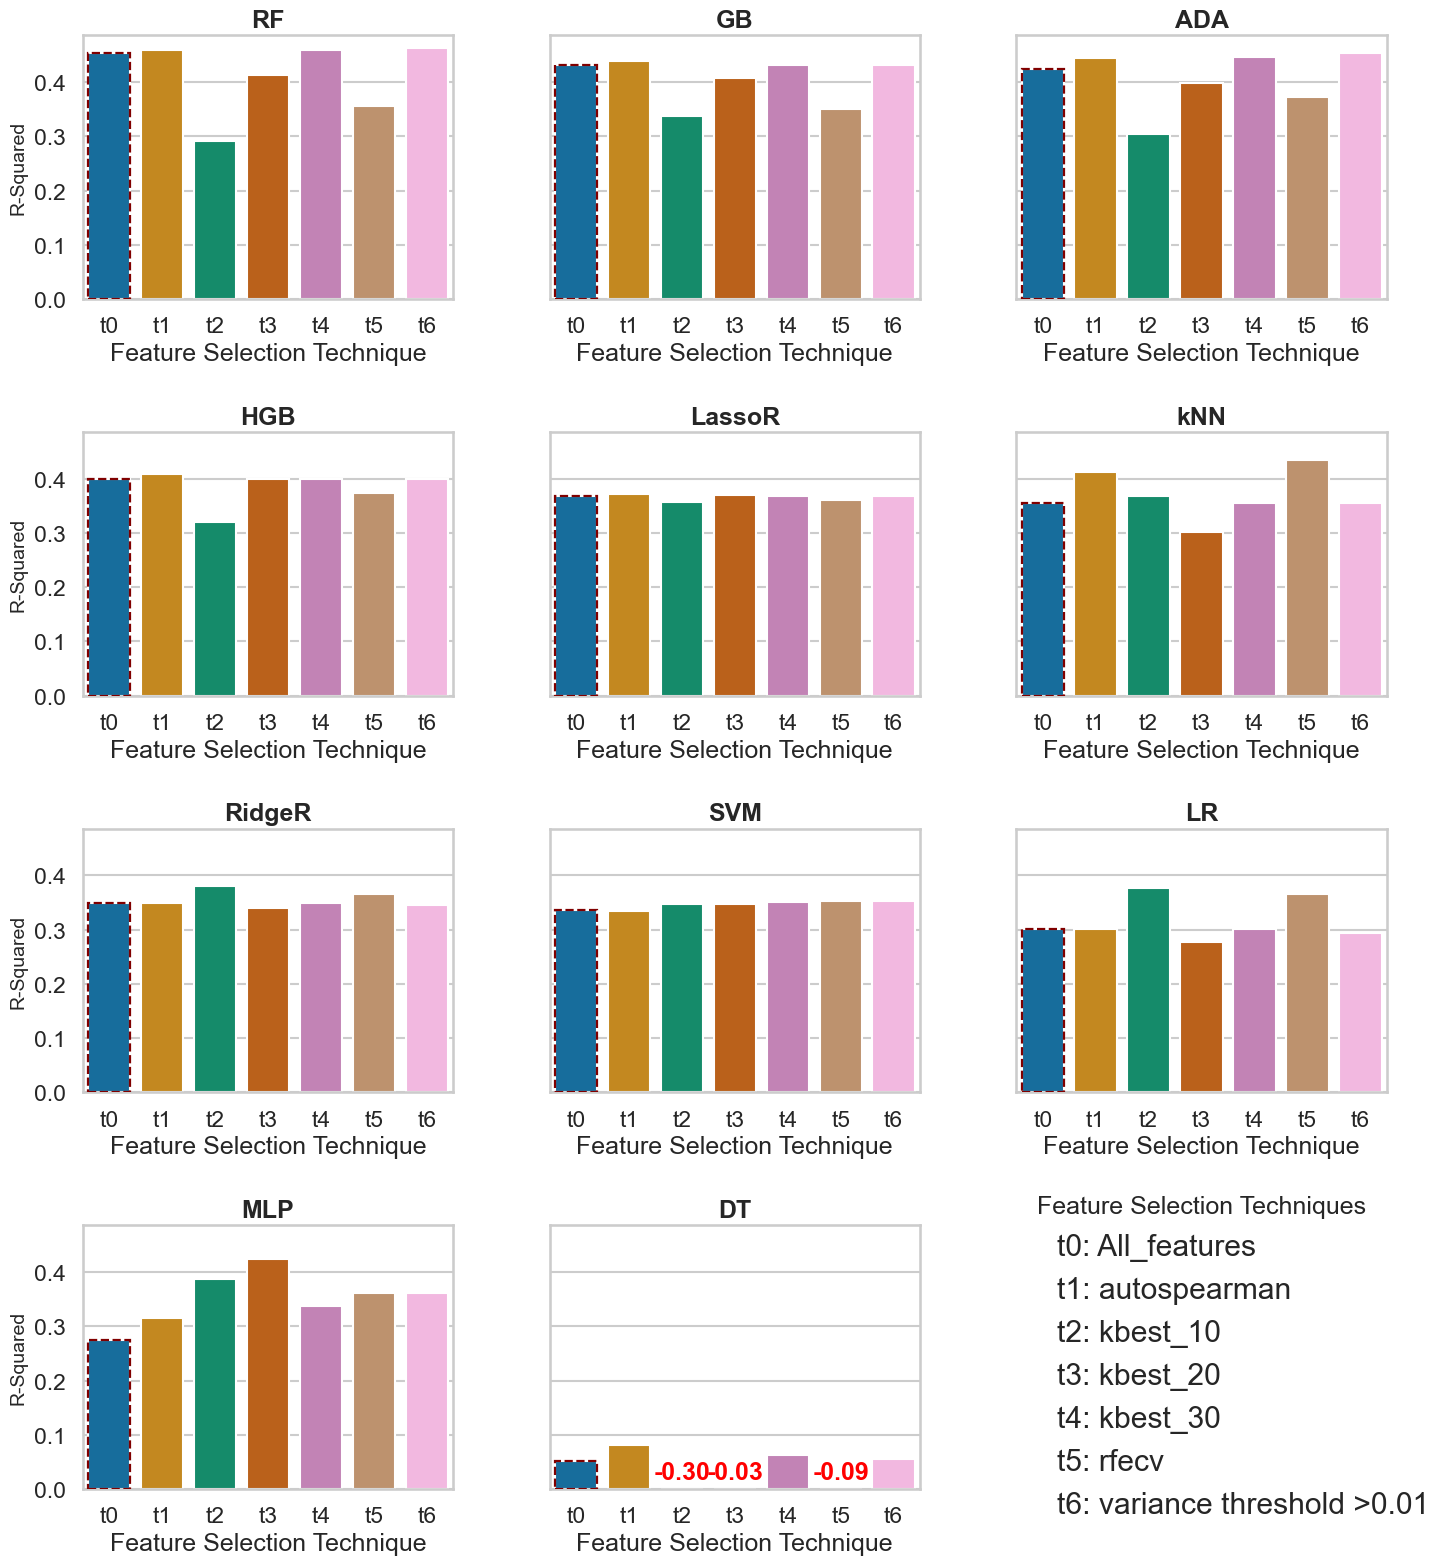

In [75]:
import math

# Filter models where all feature selection techniques are False
df_all_features = df[(df['lowVarianceDrop'] == False) &
                    (df['rfecv'] == False) &
                    (df['kbest'] == False) &
                    (df['autospearman'] == False) &
                    (df['hyperparameters'] == False)]
# Now we can sort the models based on R2 score with all features
model_order = df_all_features.groupby('model_name')['r2_mean'].mean().sort_values(ascending=False).index.tolist()
df['model_name'] = pd.Categorical(df['model_name'], categories=model_order, ordered=True)

# use the sorted model names
model_names = df['model_name'].cat.categories.tolist()
print(f"Model names: {model_names}")

# Grid size (add +1 slot for legend)
n_models = len(model_names)
n_cols = 3
n_rows = math.ceil((n_models + 1) / n_cols)  # +1 for legend

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharey=True)
axes = axes.flatten()

# Collect legend handles
all_handles = []

# Plot each model
for i, model_name in enumerate(model_names):
    ax, handles = plot_model_config_r2(model_name=model_name, df=df, ax=axes[i])
    all_handles.extend(handles)

    # Only show y-axis label for first column in each row
    if i % n_cols == 0:
        ax.set_ylabel("R-Squared", fontsize=14)
    else:
        ax.set_ylabel("")

# Deduplicate legend handles
handles_dict = {h.get_label(): h for h in all_handles}
unique_handles = list(handles_dict.values())
print(f"Collected {len(unique_handles)} unique legend handles.")

# Reserve last subplot for legend
legend_ax_index = len(model_names)
if legend_ax_index < len(axes):
    legend_ax = axes[legend_ax_index]
    legend_ax.axis('off')  # Hide plot area
    legend_ax.legend(handles=unique_handles, title='Feature Selection Techniques',
                     loc='center', ncol=1, fontsize='large', frameon=False)
else:
    print("Warning: no space left for legend in grid.")

# Hide any remaining unused axes
for j in range(len(model_names) + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig("plt_RQ2_allModels_R2.pdf", bbox_inches='tight')
plt.show()
